# Histograms for host galaxy properties

This notebook creates histograms plotting pew and velocity binned by the median of individual host gal properties. These are created for individual features. They also show anderson darling p values. 

It creates a plot of p values as the binning cutoff moves from the median. 

It removes certain outliers from the branch classification plot and host gal property plots in the phase_evolution notebook and observes how the p value changes, provided in a dataframe. 

In [32]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sndata.csp import DR3
from sndata.sdss import Sako18Spec

from utils import feature_alias, read_in_pipeline_result

warnings.simplefilter('ignore')

path = '/Users/emilysf098/Desktop/Research/SN-Spectral-Evolution'

## Reading in Data

We read in pipeline results and drop outliers. Not that we create several sets of data with different groups of outliers excluded. In principle we will only create plots in this notebook using a single outlier definition. However, we define them all here so they can be used to create new plots when working with the notebook interactively.

In [2]:
sdss_combined = read_in_pipeline_result('../results/final_sdss.csv', 'sdss')
sdss_combined = sdss_combined[sdss_combined.is_peak]

branch_outliers = [10449, 16021, 1371, 6773, 7147, 16099, 16281, 18375, 18697, 21502]
no_branch_out = sdss_combined.drop(branch_outliers, level='obj_id')

hostmass_outliers = [16280, 3901, 2330, 1580, 15369, 6422, 13072, 16333]
no_mass_out = sdss_combined.drop(hostmass_outliers, level='obj_id')

sfr_outliers = [1580, 1253, 20350, 16280, 16333]
no_sfr_out = sdss_combined.drop(sfr_outliers, level='obj_id')

redshift_outliers = [16280, 3901, 17825, 2330, 1580, 15369, 13072, 5737, 5994, 16287, 6422, 6933, 16333]
no_zCMB_out = sdss_combined.drop(redshift_outliers, level='obj_id')

all_outliers = set(branch_outliers + hostmass_outliers + sfr_outliers + redshift_outliers)
no_out = sdss_combined.drop(all_outliers, level='obj_id')


## Creating DataFrames of Binned Data by Median

We sperate the data (without outliers) into two subsets by picking a measureed value (e.g., host galaxy star formation rate) and seperating data above and below the median value of that measured value. We then create histograms comparing the two subsets.

In [3]:
def split_data_by_value(df, col, cutoff=None):
    """Return data above and below the given cutoff
    
    Args:
        df (DataFrame): Data to apply the cutoff too
        col      (Str): The cutoff to apply the cutoff on
        cutoff (float): The cutoff value (defaults to the median value of ``col``)
        
    Returns:
        Dataframe were all values in the specified column are > the cutoff
        Dataframe were all values in the specified column are <= the cutoff
    """

    df = df.dropna(subset=[col]) 
    cutoff = cutoff or df[col].median()
    high = df[df[col] > cutoff]
    low = df[df[col] <= cutoff]
    
    return high, low


In [4]:
def make_hist(df, x_col, hist_col, cutoff=None, num_bins=None, figsize=(15,20)):
    """Creates histograms of binned high and low data (by median)
    and anderson-darling p value
    
    Args:
        df  (DataFrame): Data from the analysis pipeline
        x_col     (str): Column in ``df`` to bin by in the histogram
        hist_col  (str): Split data into two histograms based on this columns
        cutoff  (float): The cutoff value (defaults to the median value of ``hist_col``)
        num_bins  (int): Optionally specify the number of bins
        figsize (tuple): The size of the resulting figure
    """
    
    fig, axes = plt.subplots(4, 2, figsize=figsize)    
    high_data, low_data = split_data_by_value(df, hist_col, cutoff=cutoff)
    for i, ax in enumerate(axes.flatten()):
        feat_name = f'pW{i + 1}'
        feat_alias = feature_alias[feat_name]
        
        ax.set_title(feat_alias, loc='left')
        ax.set_xlabel(x_col)
        ax.set_ylabel('Number of Supernovae')
        
        try:
            high_feat_data = high_data.loc[feat_name]
            low_feat_data = low_data.loc[feat_name]
        
        except KeyError:
            continue
            
        high_x = high_feat_data[x_col]
        low_x = low_feat_data[x_col]          
        
        ax.hist(high_x, label = f'high ({len(high_feat_data)})', bins=num_bins)
        ax.hist(low_x, histtype='step', hatch='//', linewidth=2, label = f'low ({len(low_feat_data)})', bins=num_bins)
        
        # Update title with p-value
        anderson = stats.anderson_ksamp([high_x, low_x]).significance_level
        ax.set_title(f'{feat_alias} (p = {anderson:.3f})', loc='left')
        ax.legend()
    

In [5]:
def plot_pvalue(df, x_col, hist_col, cutoff=None, cutoff_range=.1, cutoff_steps=20, figsize=(10, 8)):
    
    
    fig, axis = plt.subplots(figsize=figsize)
    
    
    cutoff = cutoff or df[hist_col].median()
    cutoff_min = (1 - cutoff_range) * cutoff
    cutoff_max = (1 + cutoff_range) * cutoff
    cutoff_values = np.linspace(cutoff_min, cutoff_max, cutoff_steps)
    
    for i in range(1, 9):
        feat_name = f'pW{i}'
        if feat_name not in df.index:
            continue
            
        feat_data = df.loc[feat_name]
        cut_value = []
        p_value = []
        
        for cut in cutoff_values:
            high_data, low_data = split_data_by_value(feat_data, hist_col, cutoff=cut)
            anderson_data = [high_data[x_col], low_data[x_col]]
            
            if any(data.empty for data in anderson_data):
                continue
            
            cut_value.append(cut)
            p_value.append(stats.anderson_ksamp(anderson_data).significance_level)

        axis.plot(cut_value, p_value, label=feature_alias[feat_name])
        axis.legend(loc='upper left', framealpha=1)
        
    axis.fill_between(cutoff_values, np.zeros_like(cutoff_values), np.full_like(cutoff_values, .05), color='grey', alpha=.1)
    axis.axvline(cutoff, color='k', linestyle='--')
    
    axis.set_ylim(0, .3)
    axis.set_xlim(min(cutoff_values), max(cutoff_values))
    

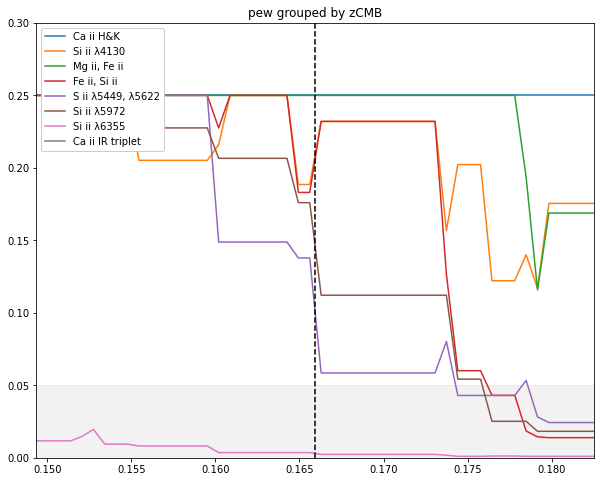

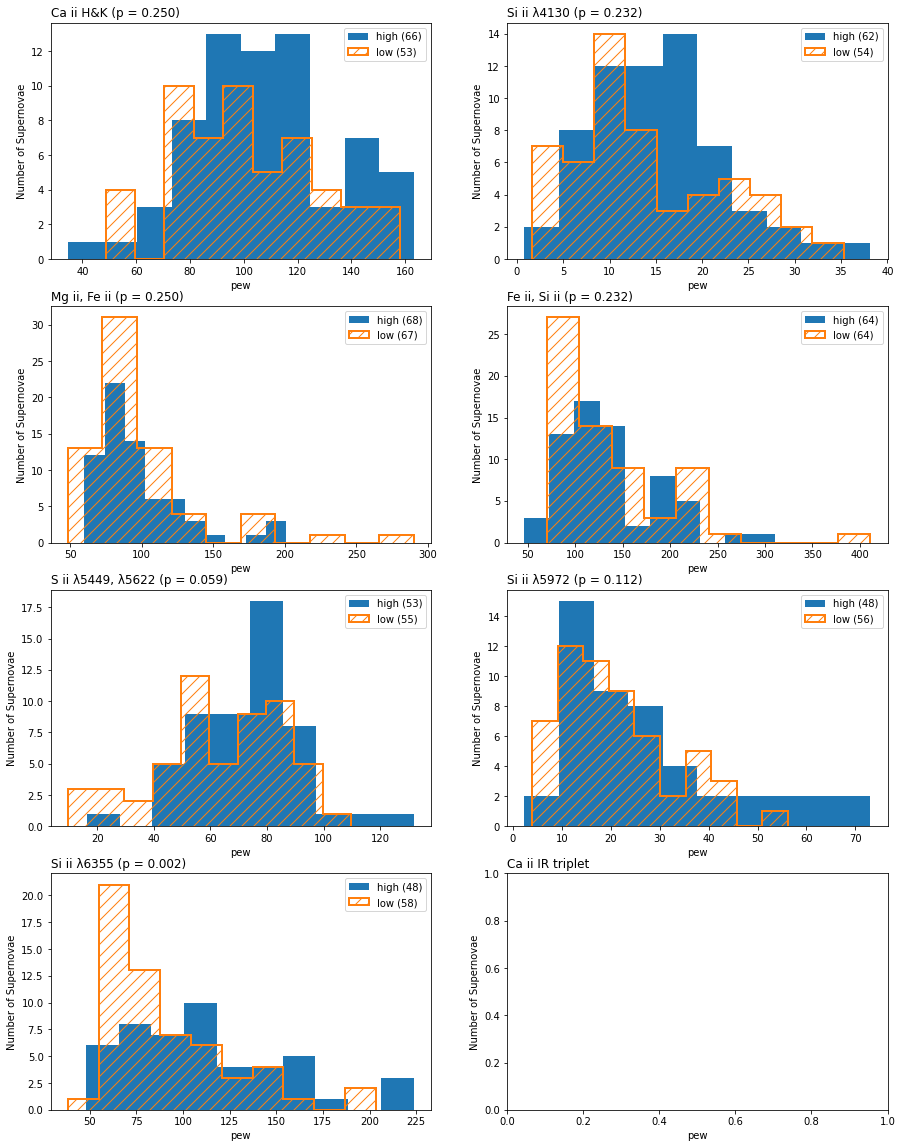

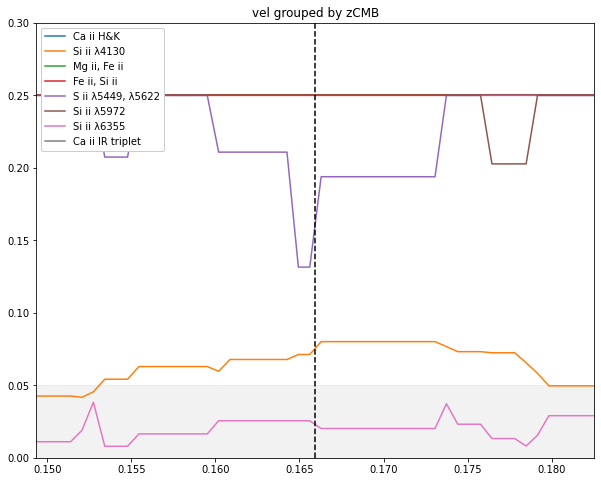

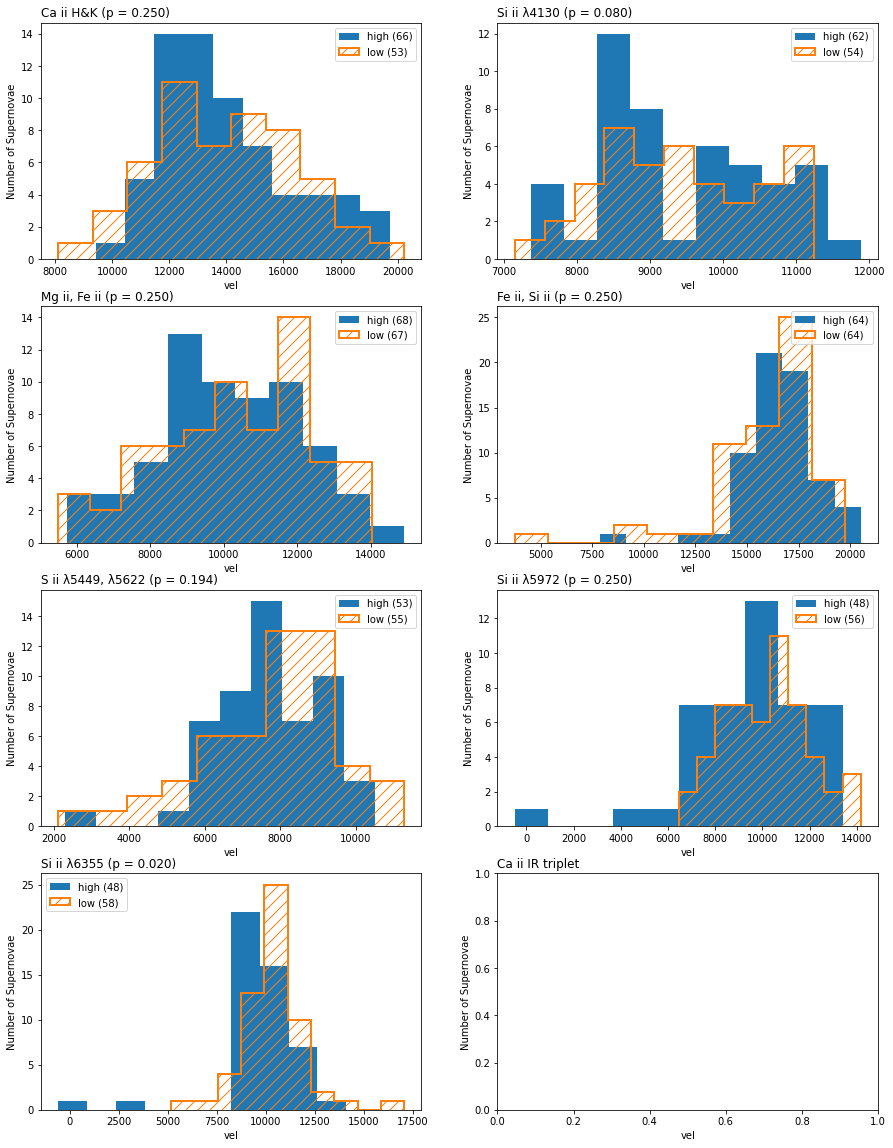

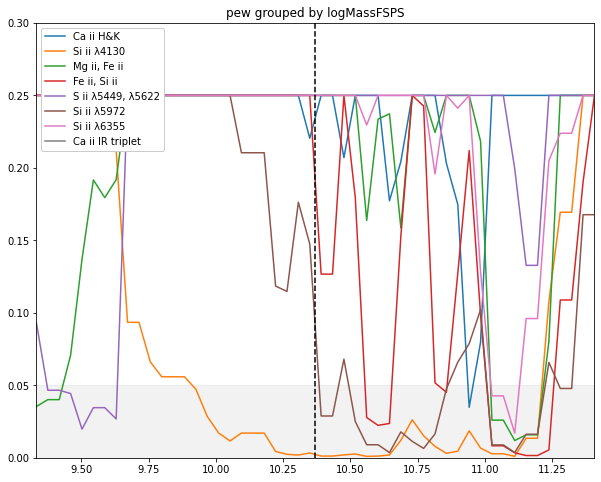

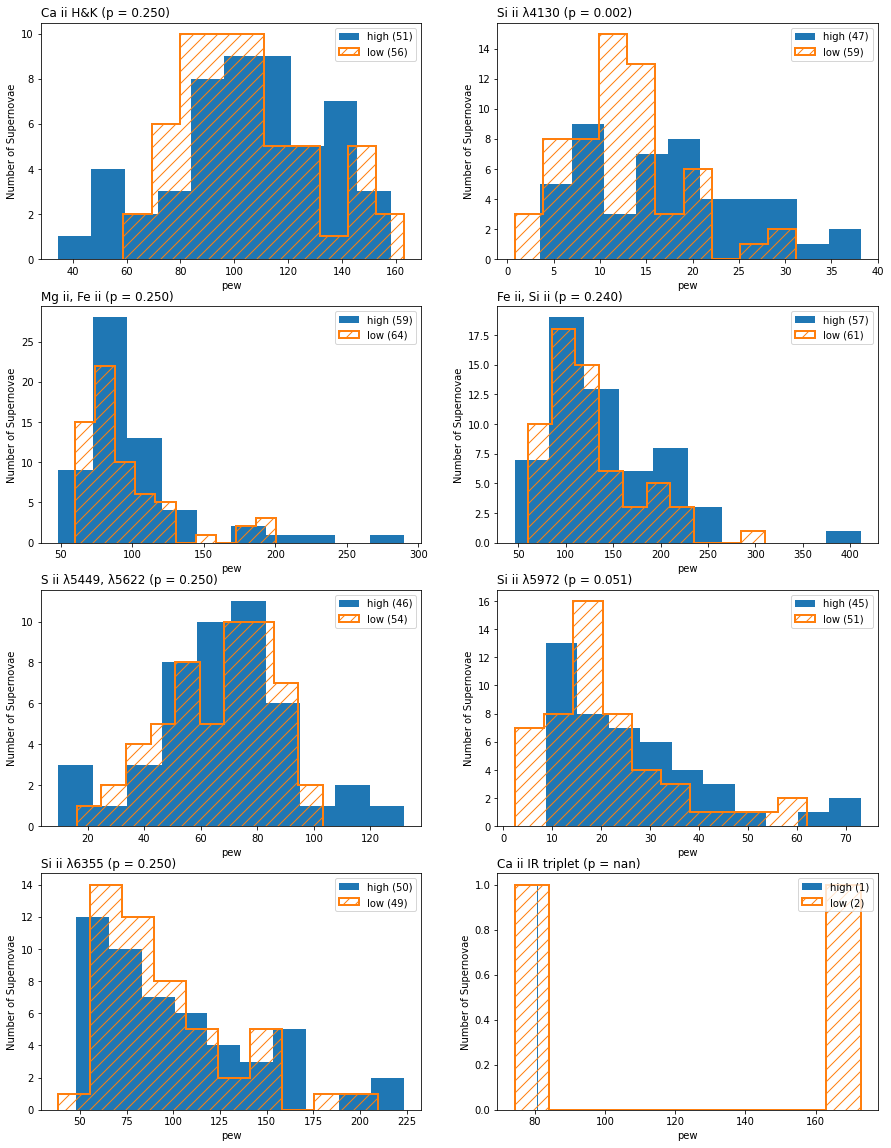

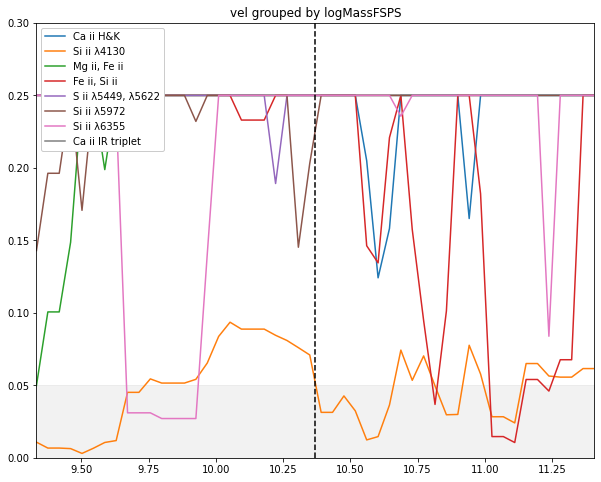

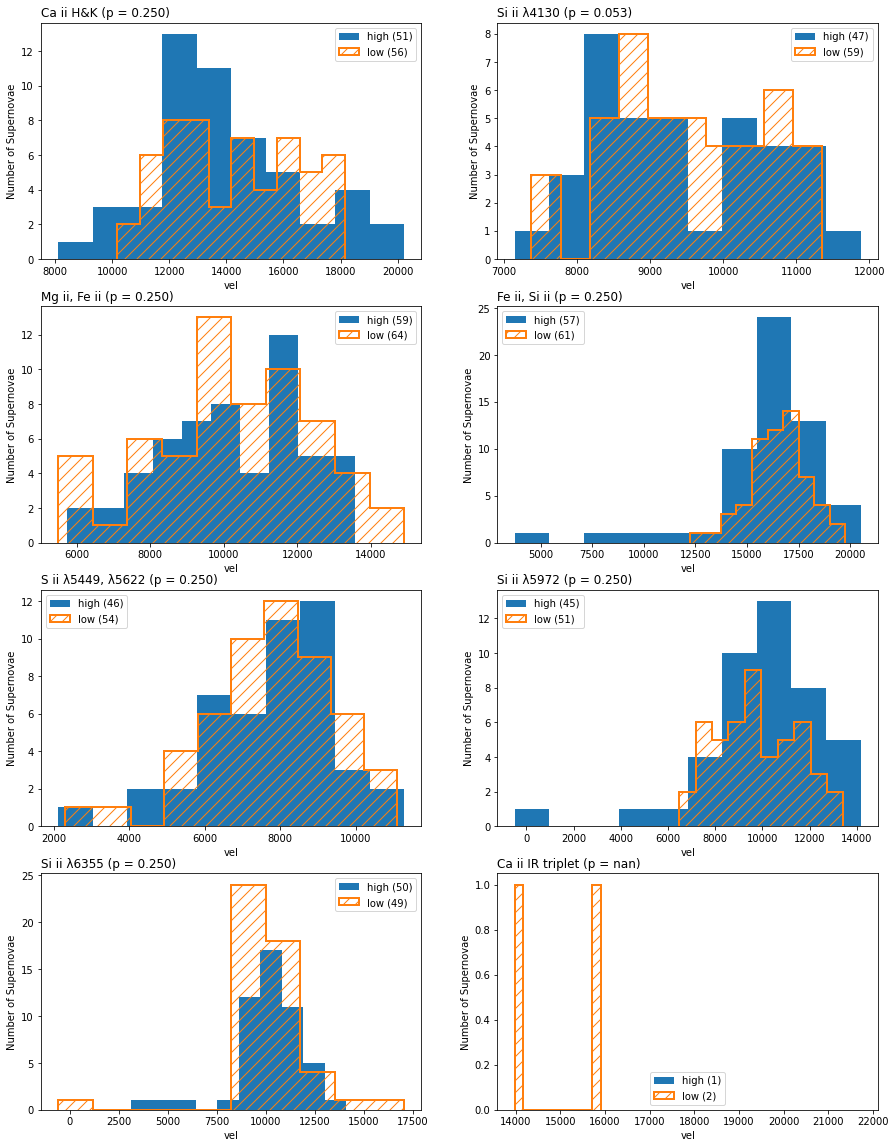

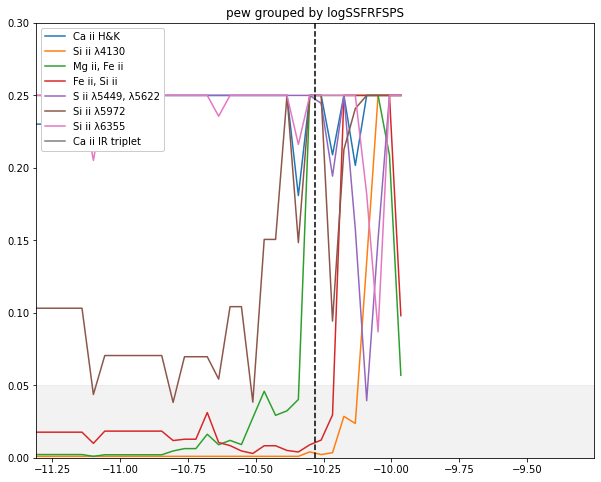

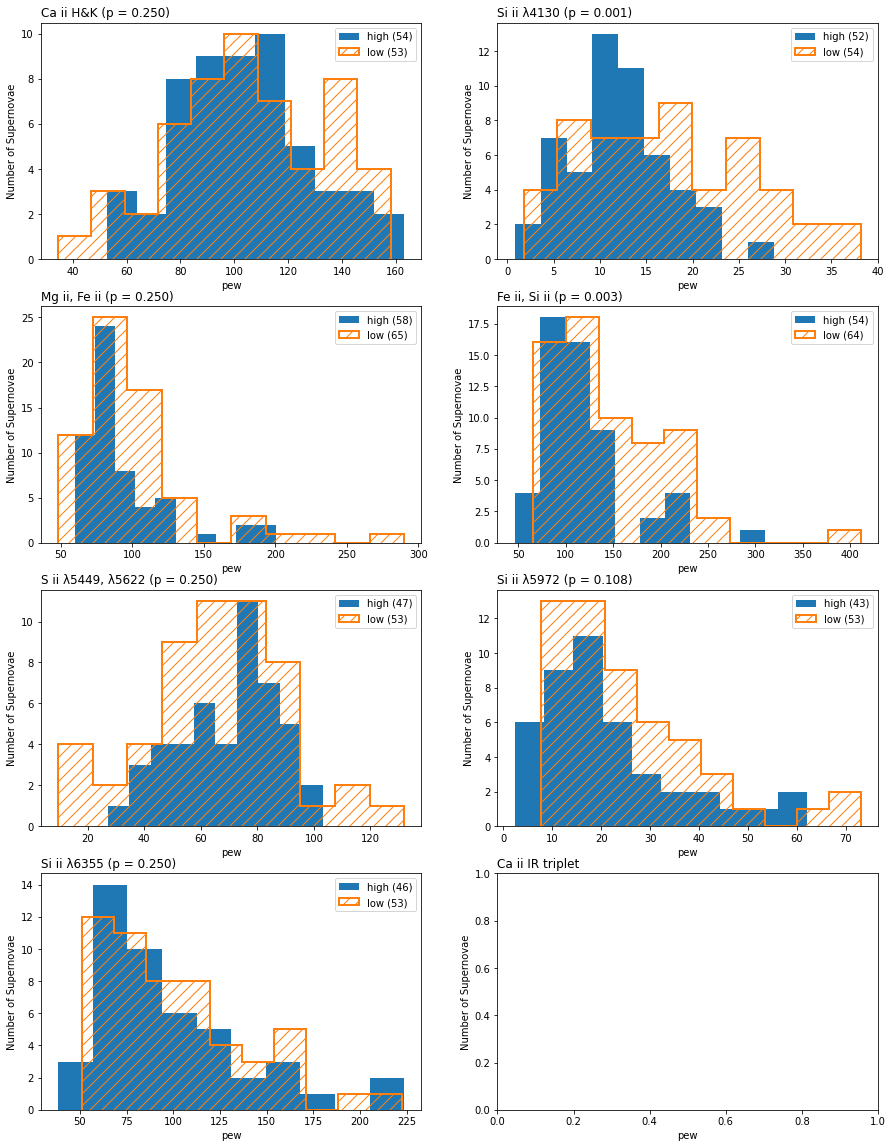

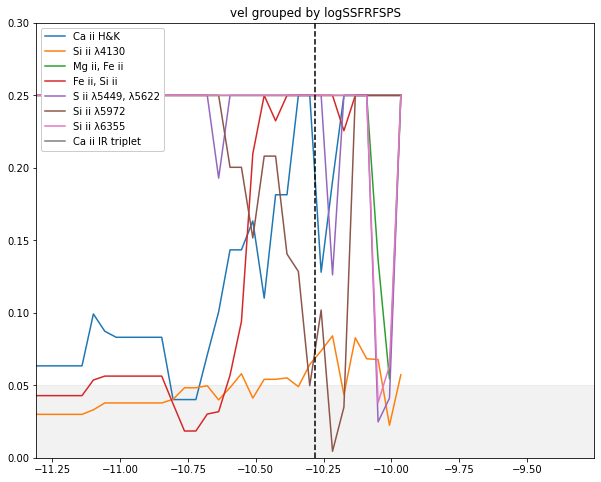

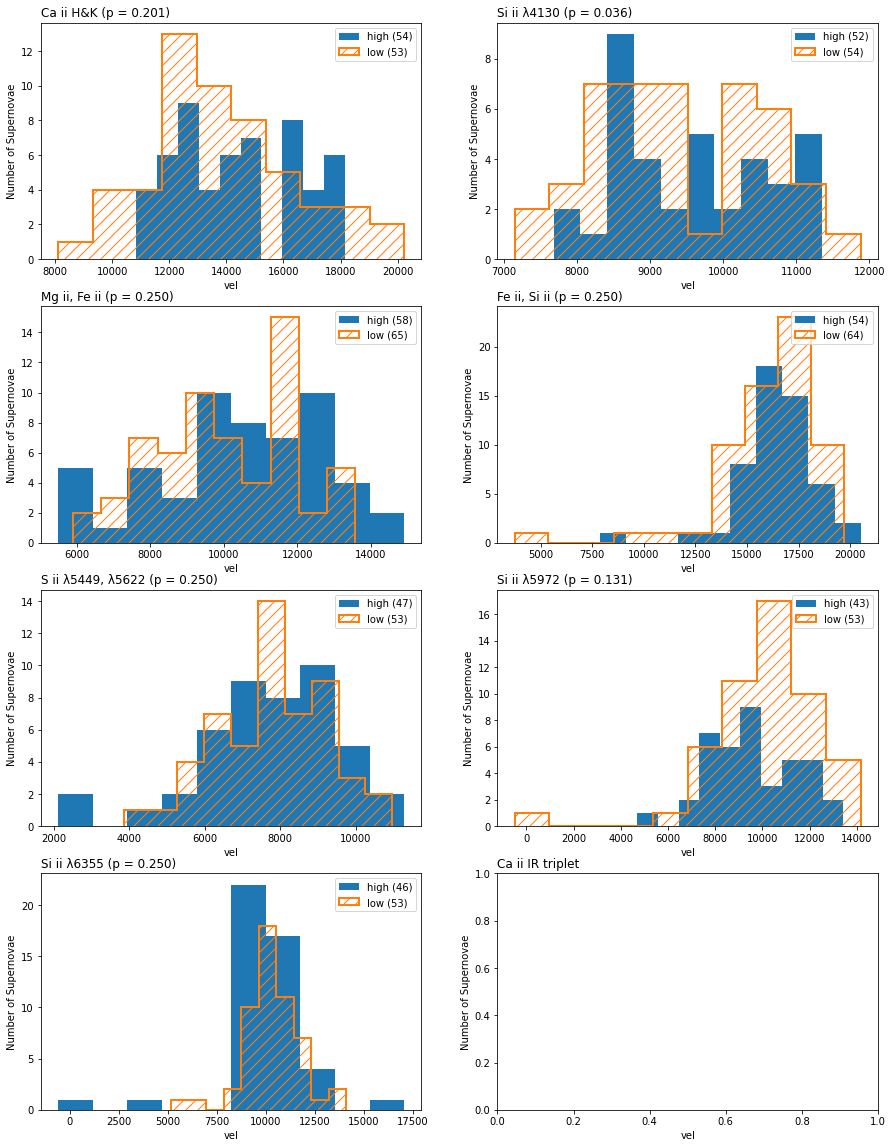

In [6]:
for col in ('zCMB', 'logMassFSPS', 'logSSFRFSPS'):
    for measurement in ('pew', 'vel'):
        plot_pvalue(no_out, measurement, col, cutoff_steps=50)
        plt.title(f'{measurement} grouped by {col}')
        make_hist(no_out, measurement, col)


In [15]:
def make_hist_tables(df, x_col, hist_col, cutoff=None, num_bins=None, figsize=(15,20)):
    """Creates tables of binned high and low data (by median)
    and anderson-darling p value
    
    Args:
        df  (DataFrame): Data from the analysis pipeline
        x_col     (str): Column in ``df`` to bin by in the histogram (pew or vel)
        hist_col  (str): Split data into two histograms based on this columns (host gal prop)
        cutoff  (float): The cutoff value (defaults to the median value of ``hist_col``)
        num_bins  (int): Optionally specify the number of bins
        figsize (tuple): The size of the resulting figure
    """
    
    feat_name_ls = []
    anderson_ls = []
    num_low_ls = []
    num_high_ls = []
    
    
    high_data, low_data = split_data_by_value(df, hist_col, cutoff=cutoff)
    
    
    for i in range(0,7):
        feat_name = f'pW{i + 1}'
        feat_alias = feature_alias[feat_name]


        try:
            high_feat_data = high_data.loc[feat_name]
            low_feat_data = low_data.loc[feat_name]

        except KeyError:
            continue

        high_x = high_feat_data[x_col]
        low_x = low_feat_data[x_col] 

        anderson = stats.anderson_ksamp([high_x, low_x]).significance_level
        
        num_low = len(low_feat_data)
        num_high = len(high_feat_data)

        feat_name_ls.append(feat_name)
        anderson_ls.append(anderson)
        num_low_ls.append(num_low)
        num_high_ls.append(num_high)


    data = {'feature': feat_name_ls, 'p-value' : anderson_ls, 'N low' : num_low_ls, 'N high' : num_high_ls}   
    
    df = pd.DataFrame(data)
    return df

In [17]:
df_ls = []

for col in ('zCMB', 'logMassFSPS', 'logSSFRFSPS'):
    for measurement in ('pew', 'vel'):
        new_df = make_hist_tables(no_out, measurement, col)
        df_ls.append(new_df)

In [33]:
df_zCMB = df_ls[0]
df_zCMB_vel = df_ls[1]
df_zCMB['vel p-value'] = df_zCMB_vel['p-value']
df_zCMB.rename(columns = {'p-value' : 'pew p-value'}, inplace=True)
df_zCMB = df_zCMB[['feature', 'pew p-value', 'vel p-value', 'N low', 'N high']]
df_zCMB = df_zCMB.set_index('feature')

df_zCMB.to_csv(path + '/results/anderson_zCMB.csv')

df_mass = df_ls[2]
df_mass_vel = df_ls[3]
df_mass['vel p-value'] = df_mass_vel['p-value']
df_mass.rename(columns = {'p-value' : 'pew p-value'}, inplace=True)
df_mass = df_mass[['feature', 'pew p-value', 'vel p-value', 'N low', 'N high']]
df_mass = df_mass.set_index('feature')

df_mass.to_csv(path + '/results/anderson_mass.csv')

df_ssfr = df_ls[4]
df_ssfr_vel = df_ls[5]
df_ssfr['vel p-value'] = df_ssfr_vel['p-value']
df_ssfr.rename(columns = {'p-value' : 'pew p-value'}, inplace=True)
df_ssfr = df_ssfr[['feature', 'pew p-value', 'vel p-value', 'N low', 'N high']]
df_ssfr = df_ssfr.set_index('feature')

df_ssfr.to_csv(path + '/results/anderson_ssfr.csv')

In [34]:
df_ssfr

,pew p-value,vel p-value,N low,N high
feature,,,,
pW1,0.250000,0.200595,53,54
pW2,0.001000,0.035596,54,52
pW3,0.250000,0.250000,65,58
pW4,0.003087,0.250000,64,54
pW5,0.250000,0.250000,53,47
pW6,0.108278,0.131132,53,43
pW7,0.250000,0.250000,53,46
